In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn import metrics
import tabulate
import scipy
import itertools
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from collections import Counter
import umap
from importlib import reload
from scipy import stats
import matplotlib.image as mpimg
import goatools
from goatools.anno.gaf_reader import GafReader
import Bio.UniProt.GOA as GOA
from sklearn import metrics
from sklearn.decomposition import PCA
import tabulate
import itertools
import igraph as ig
import matplotlib.patches as mpatches
from sklearn.neighbors import radius_neighbors_graph
from scipy.ndimage import gaussian_filter1d
from sklearn.neighbors import kneighbors_graph
from scipy.spatial.distance import pdist, squareform
import leidenalg as la
import dask.array as da
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import umap
import bbknn
import bbknn.matrix
from importlib import reload
from scipy import stats
import matplotlib.image as mpimg
from goatools.anno.gaf_reader import GafReader
import Bio.UniProt.GOA as GOA
import gget
import sys

# locals
sys.path.append("../")
import utils as ut
reload(ut)

2023-03-04 13:18:09.677973: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 13:18:09.790326: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2023-03-04 13:18:09.790343: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-04 13:18:09.816374: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-04 13:18:10.4956

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/clustering/../utils.py'>

In [2]:
clusterPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/clusters.csv"
cf = pd.read_parquet(clusterPath)
print(cf.shape)
print(cf['cellType'].unique())
cf.head()

(427882, 7)
['Macrophages' 'B cells' 'Monocytes' 'NK cells' 'Dendritic cells'
 'T cells' 'Stromal cells']


,gene,scores,pvals,logfoldchanges,clusterId,key,cellType
0,H2-EB1,36.343353,4.575346e-181,3.564091,1,ND,Macrophages
1,H2-AA,35.311523,4.761517e-183,3.430534,1,ND,Macrophages
2,H2-AB1,34.411163,2.815112e-177,3.234597,1,ND,Macrophages
3,CD74,33.910587,2.451588e-177,3.302062,1,ND,Macrophages
4,H2-DMA,31.695400,2.991793e-123,2.667091,1,ND,Macrophages


In [3]:
"""load scRNA"""
dirPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/"

rna = {}

for f in os.listdir(dirPath):
    
    if f.endswith('.h5ad'):
        key = f.split(".")[0]
        fullPath = f"{dirPath}{f}"
        data = sc.read(fullPath)
        rna[key] = data
    
print("done")

done


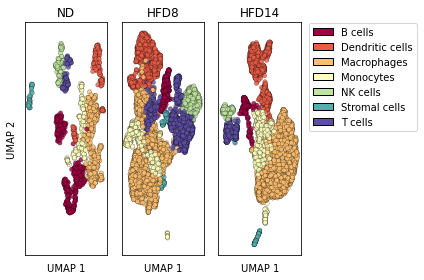

In [4]:
# plot clusters using individual embeddings
# shows how well defined the clusters are at a single time point
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 12, 4
plt.rcParams['figure.facecolor'] = 'w'

keys = ['ND', 'HFD8', 'HFD14']

ncolors = cf['cellType'].nunique()
ctypes = sorted(cf['cellType'].unique())

colordict = dict(zip(ctypes, ut.ncolor(ncolors, cmap='Spectral')))

fig, axs = plt.subplots(1, 3, sharey=True)
axs = axs.ravel()


for i, key in enumerate(keys):
    data = rna[key]
        
    # get the run key
    allKeys = list(data.obs.keys() )
    allKeys.remove('n_genes')
    runKey = allKeys[0]
    
    clusterIds = data.obs[runKey].astype(int) + 1  # note that these are zero-indexed!
    embedding = data.obsm['X_umap']
    
    # get coloring
    c = ['k'] * len(embedding)
    handles = []
    
    for ctype in ctypes:
        mask = (cf['cellType'] == ctype) & (cf['key'] == key)
        cids = cf[mask]['clusterId'].unique()
        c = np.where(clusterIds.isin(cids), colordict[ctype], c)
        
        handle = mpatches.Patch(color=colordict[ctype], 
                                ec='k', 
                                label=ctype)
        handles.append(handle)
        
    
    axs[i].scatter(embedding[:, 0] , 
                   embedding[:, 1] , 
                   c=c,
                   edgecolor="k",
                   linewidth=0.25,
                   s=20,
                   alpha=0.8,)
    
        
    axs[i].set_title(key)
    axs[i].set_xlabel("UMAP 1")
    
    if i == 0:
        axs[i].set_ylabel("UMAP 2")
    
    _ = axs[i].set_xticks([])
    _ = axs[i].set_yticks([])

    
plt.legend(handles=handles, bbox_to_anchor=(1.04, 1.02))
plt.tight_layout()

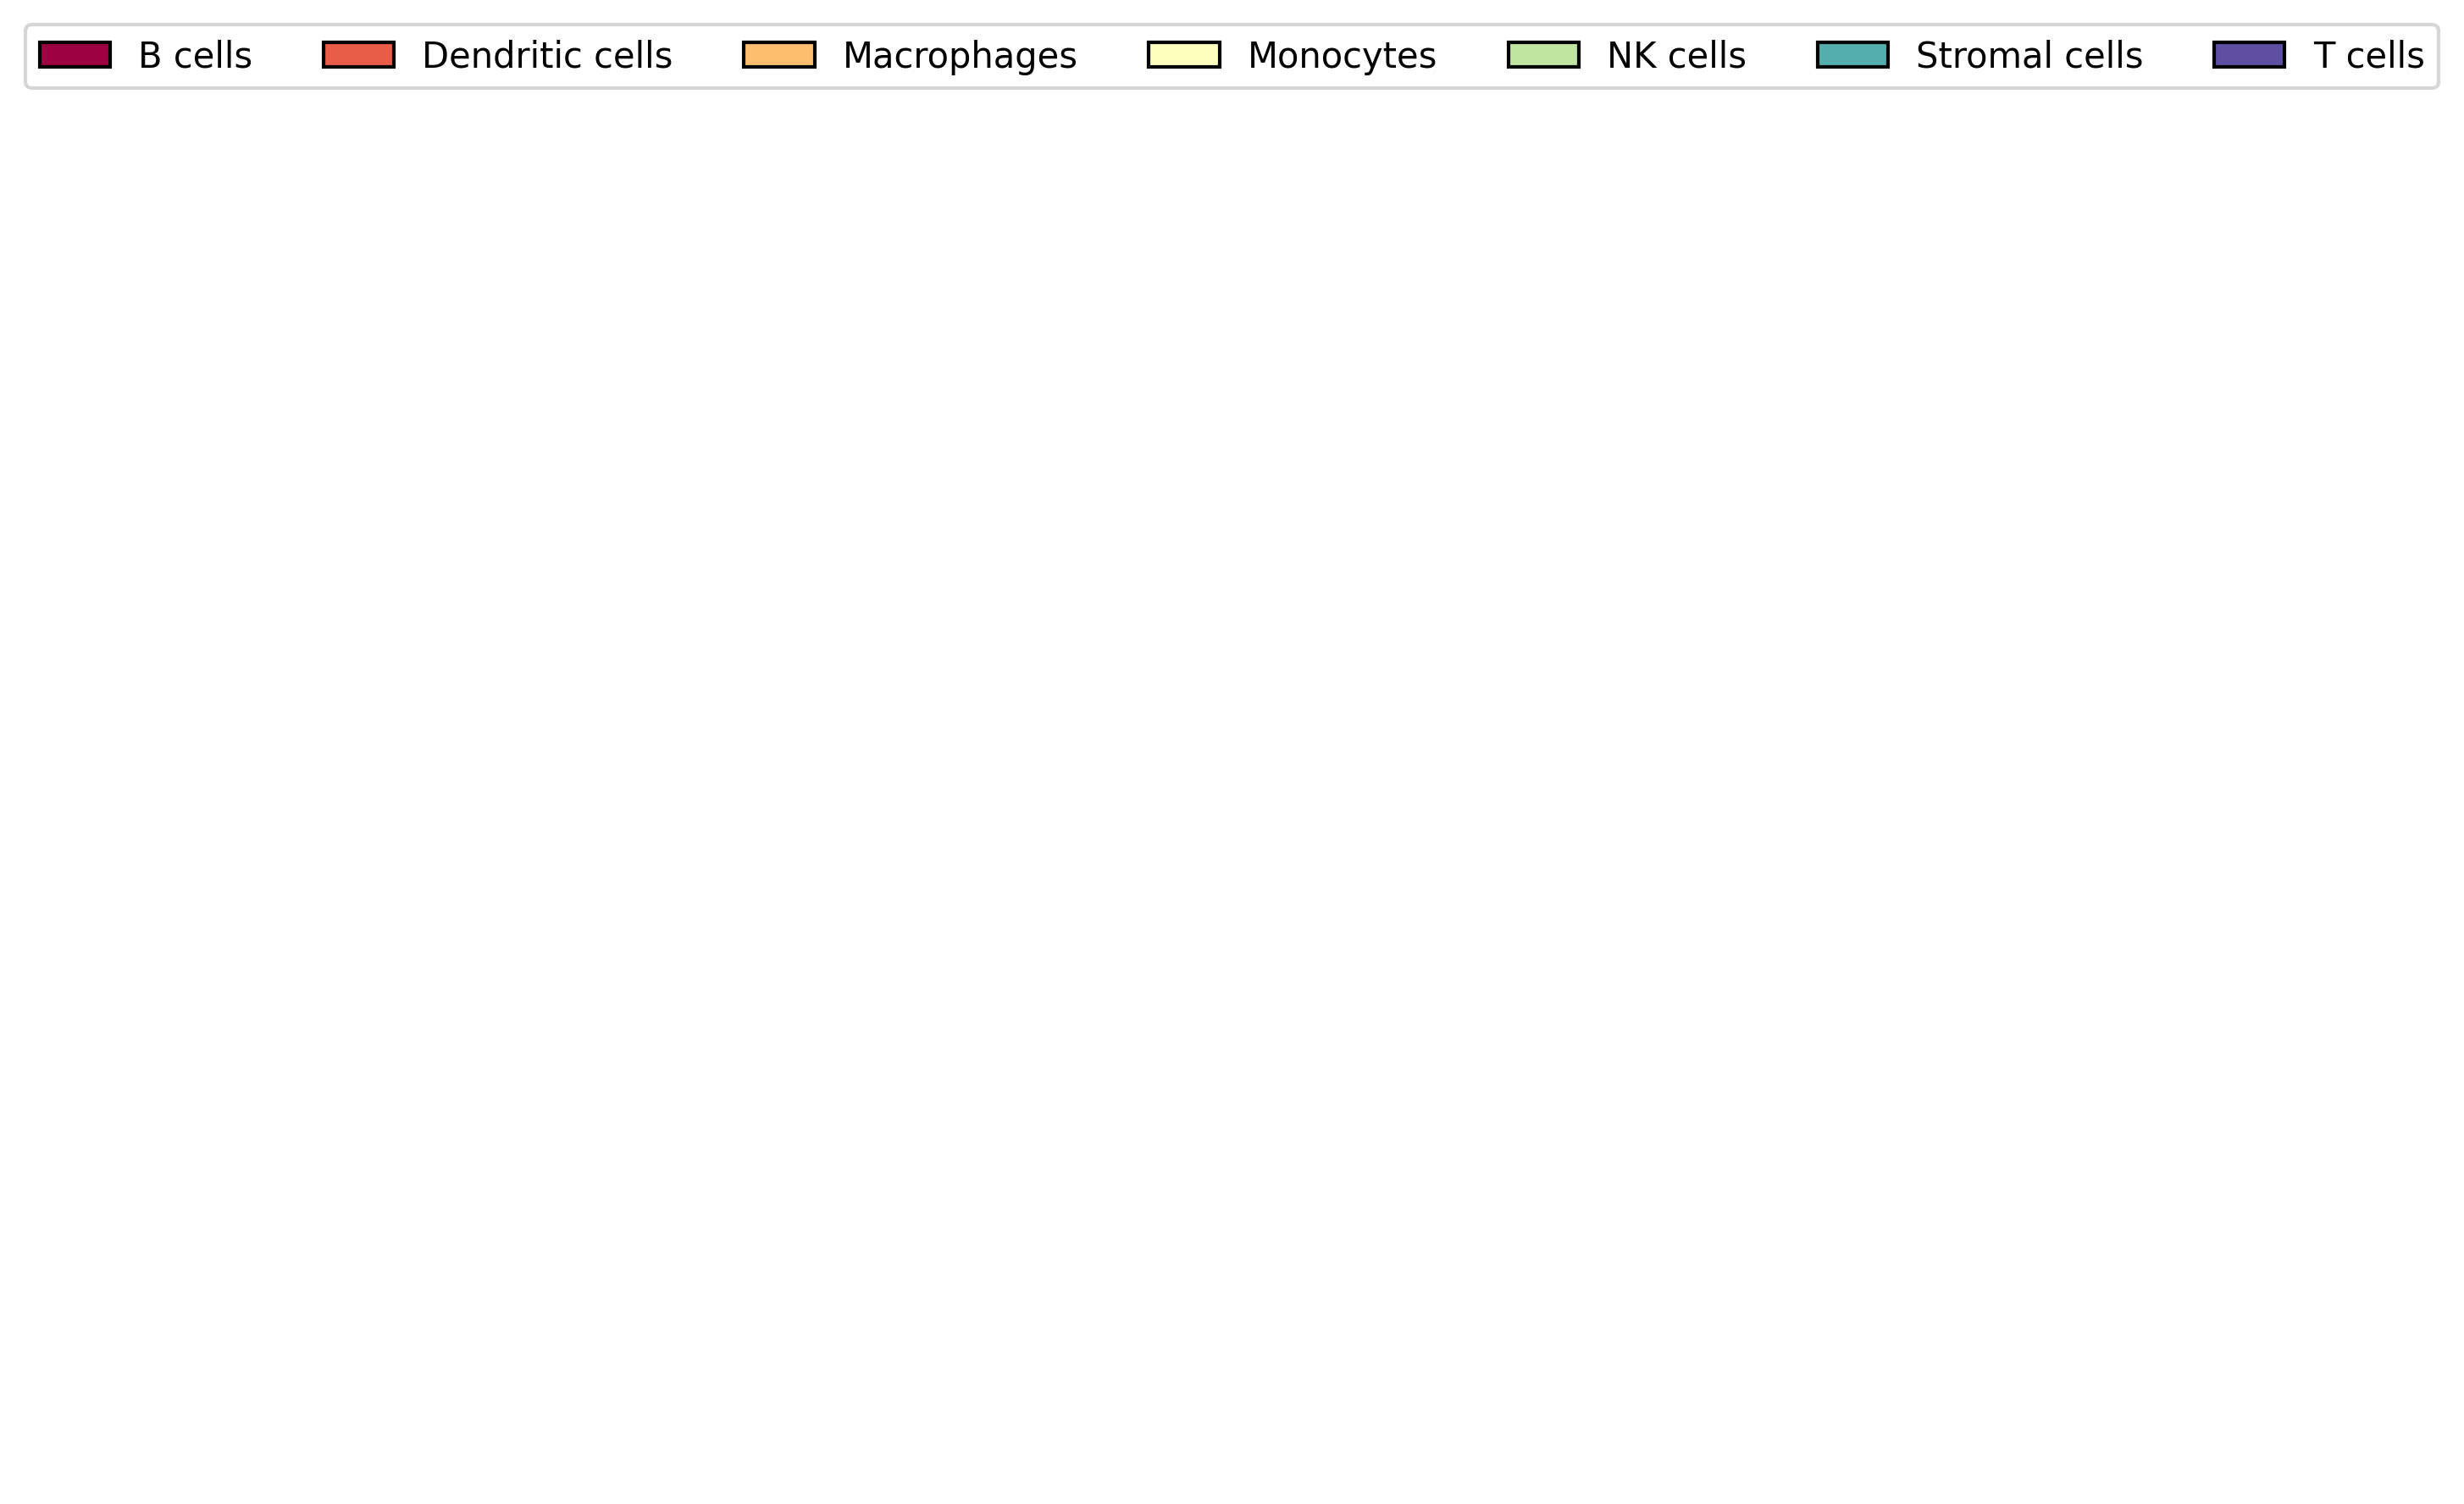

In [5]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6
plt.rcParams['figure.facecolor'] = 'w'

plt.legend(handles=handles, 
           bbox_to_anchor=(2, 1.02),
           ncols=7)
plt.axis(False)
plt.tight_layout()

In [6]:
# break

['#9e0142', '#e95c47', '#fdbf6f', '#ffffbe', '#bfe5a0', '#54aead', '#5e4fa2']

['#9e0142', '#e95c47', '#fdbf6f', '#ffffbe', '#bfe5a0', '#54aead', '#5e4fa2']

['#9e0142', '#e95c47', '#fdbf6f', '#ffffbe', '#bfe5a0', '#54aead', '#5e4fa2']



,cellType,proportion,color,key
0,B cells,0.287074,#9e0142,ND
1,Dendritic cells,0.113402,#e95c47,ND
2,Macrophages,0.284695,#fdbf6f,ND
3,Monocytes,0.138779,#ffffbe,ND
4,NK cells,0.076130,#bfe5a0,ND


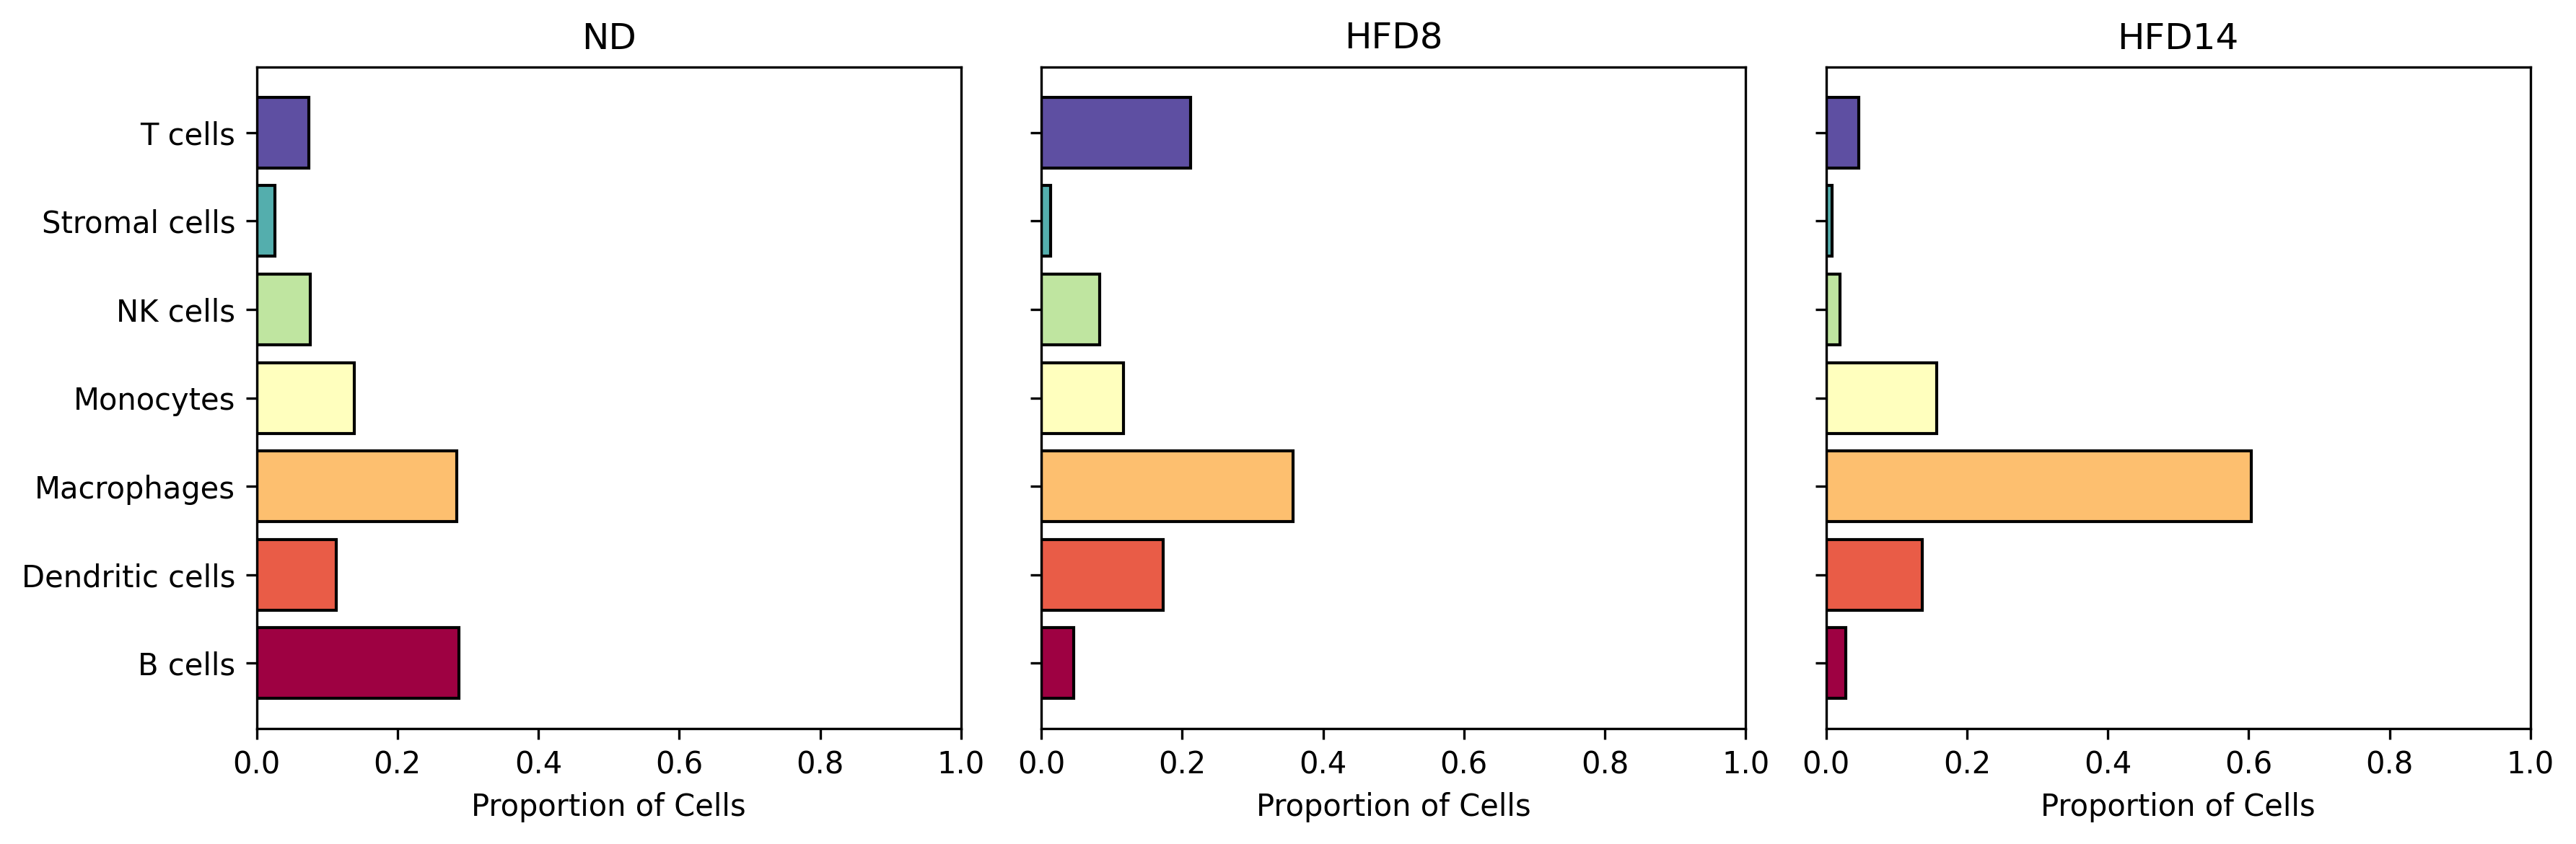

In [7]:
keys = ['ND', 'HFD8', 'HFD14']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 12, 4
plt.rcParams['figure.facecolor'] = 'w'


keys = ['ND', 'HFD8', 'HFD14']

fig, axs = plt.subplots(1, 3, sharey=True)
axs = axs.ravel()

res = []

for i, key in enumerate(keys):
    data = rna[key]
    
    clusterCount = pd.DataFrame(data.obs[runKey].astype(int).value_counts(normalize=True))
    clusterCount.columns = ['proportion'] 
    clusterCount['clusterId'] = clusterCount.index + 1
    
    # add cell types
    mask = (cf['key'] == key)
    ctdf = cf[mask]
    
    ctdf = ctdf.drop_duplicates(subset=['cellType', 'clusterId'])
    ctMapper = dict(zip(ctdf['clusterId'], ctdf['cellType']))
    
    clusterCount['cellType'] = clusterCount['clusterId'].map(ctMapper)
    
    grped = clusterCount.groupby('cellType')['proportion'].sum()
    grped = grped.sort_index(ascending=False).reset_index()
    
    grped['color'] = grped['cellType'].map(colordict)
    grped['key'] = key
    
    grped = grped.sort_values(by='cellType')
    print(grped['color'].to_list())
    print()
    
    res.append(grped)
    
    axs[i].barh(grped['cellType'],
             grped['proportion'],
             color=grped['color'],
             edgecolor='k')
    
    axs[i].set_xlabel('Proportion of Cells')
    axs[i].set_title(key)
    axs[i].set_xlim([0, 1])

plt.tight_layout()


res = pd.concat(res,ignore_index=True)
res.head()

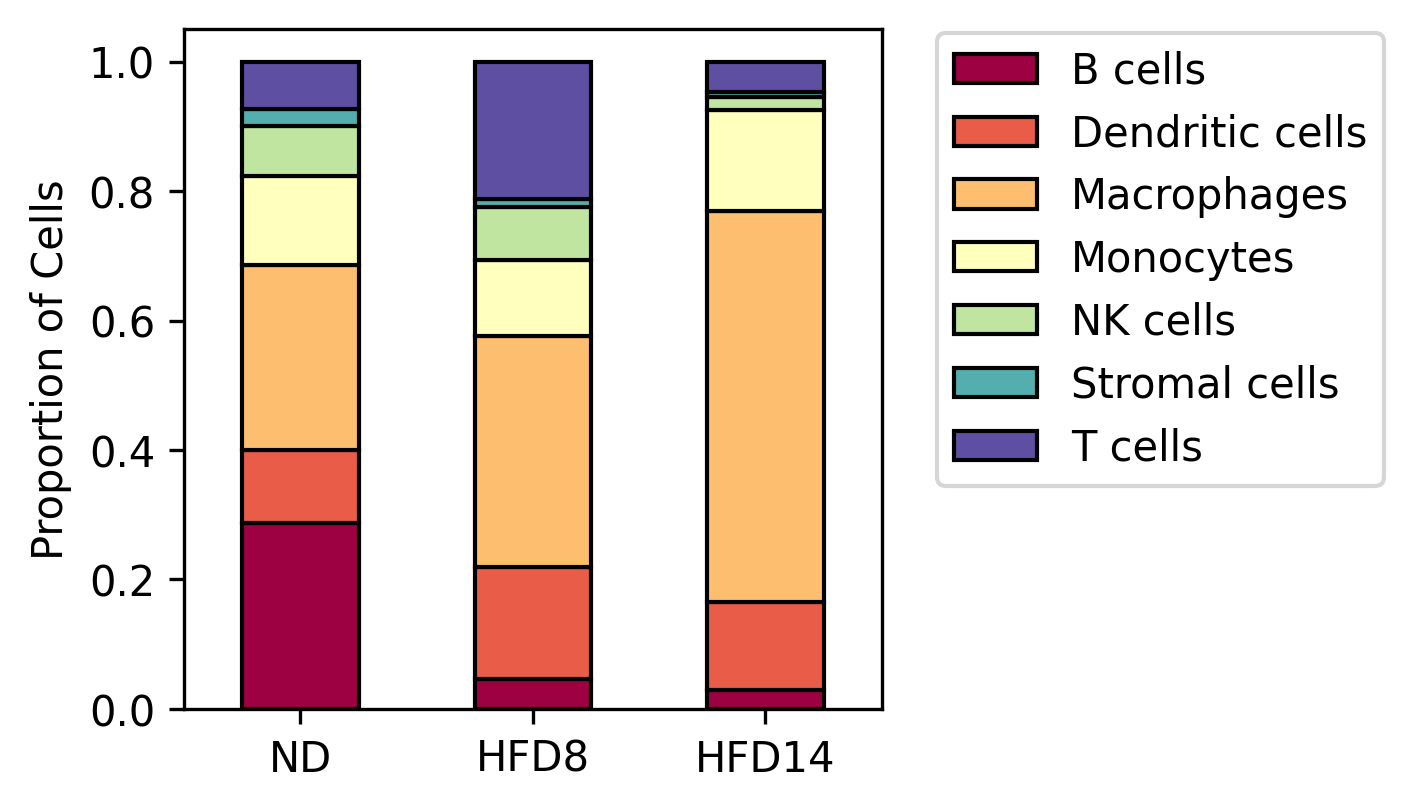

In [8]:
res = res.sort_values(by='key', ascending=False)
res2 = pd.pivot_table(res, values='proportion', index=['cellType'], columns='key').reset_index()
res2 = res2.set_index('cellType')
# res2.columns = ['ND', 'HFD8', 'HFD14']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = 'w'

# res = res.set_index('cellType')
res2.T.plot(kind='bar', stacked=True, edgecolor='k', color=['#9e0142', '#e95c47', '#fdbf6f', '#ffffbe', '#bfe5a0', '#54aead', '#5e4fa2'])
plt.legend(bbox_to_anchor=(1.05, 1.025))
plt.ylabel('Proportion of Cells')
_ = plt.xticks(rotation=0)
plt.xlabel("")
# plt.title("scRNA-seq")
plt.gca().invert_xaxis()

In [9]:
res2

key,HFD14,HFD8,ND
cellType,,,
B cells,0.028434,0.046056,0.287074
Dendritic cells,0.137042,0.172791,0.113402
Macrophages,0.603480,0.357341,0.284695
Monocytes,0.156774,0.116610,0.138779
NK cells,0.019422,0.082476,0.076130
Stromal cells,0.008390,0.012739,0.026170
T cells,0.046457,0.211988,0.073751


In [10]:
# break

In [11]:
""" a pooled approach """

allGenes = []
clusterIdList = []
colors = []
cellTypes = []
cellIds = []


for i, key in enumerate(keys):
    data = rna[key]
    df = data.to_df()
    allGenes += df.columns.to_list()
    
    allKeys = list(data.obs.keys())
    allKeys.remove('n_genes')
    runKey = allKeys[0]
    
    clusterIds = data.obs[runKey].astype(int) + 1  # note that these are zero-indexed!
    clusterIdList += list(clusterIds)
    
    cellIds += list(df.index)
    
    # get coloring
    c = ['k'] * len(df)
    cellType = ['NULL'] * len(df)
    handles = []
    
    for ctype in ctypes:
        mask = (cf['cellType'] == ctype) & (cf['key'] == key)
        cids = cf[mask]['clusterId'].unique()
        c = np.where(clusterIds.isin(cids), colordict[ctype], c)
        cellType = np.where(clusterIds.isin(cids), ctype, cellType)
        
    colors += list(c)
    cellTypes += list(cellType)
    

    # only consider genes present at all time points
allGenes = [k for (k,v) in Counter(allGenes).items() if v > 2]

keyVector = []
dfList = []

for i, key in enumerate(keys):
    data = rna[key]
    df = data.to_df()
    df = df[allGenes]
    
    keyVector += ([key] * df.shape[0])
    dfList.append(df)

X = pd.concat(dfList, ignore_index=True)
X = X.to_numpy()

""" PCA """
r = 10
pca = PCA(n_components=r)
pcaModel = pca.fit(X)
Xpca = pca.fit_transform(X)

""" UMAP """

# plotting params
n_components = 2 # should always be 2
n_neighbors = 50
min_dist = 0.25
metric= "euclidean"

umap_reducer = umap.UMAP(n_components=n_components,
                         n_neighbors=n_neighbors,
                         min_dist=min_dist,
                         metric=metric)

ef = umap_reducer.fit_transform(Xpca) # we need embedding by cell
ef = pd.DataFrame(ef)
ef.columns = ['x', 'y']
ef['key'] = keyVector
ef['clusterId'] = clusterIdList
ef['colors'] = colors
ef['cellTypes'] = cellTypes
ef['cellId'] = cellIds
ef['cellId'] = ef['cellId'].apply(lambda x: x.replace("-", "."))

print(ef['key'].value_counts(normalize=False))
print()
print(ef['cellTypes'].value_counts(normalize=True))
print()
ef.head()

HFD14    6436
HFD8     6123
ND       1261
Name: key, dtype: int64

Macrophages        0.465340
Dendritic cells    0.150724
Monocytes          0.137337
T cells            0.122287
B cells            0.059841
NK cells           0.052533
Stromal cells      0.011939
Name: cellTypes, dtype: float64



,x,y,key,clusterId,colors,cellTypes,cellId
0,6.861383,1.604622,ND,4,#9e0142,B cells,AAACGAACAGCAGTAG.1
1,2.939032,-1.647220,ND,3,#fdbf6f,Macrophages,AAAGAACGTCTACAGT.1
2,3.521317,-1.532969,ND,3,#fdbf6f,Macrophages,AAAGAACTCCTCGCAT.1
3,3.359651,5.884222,ND,1,#fdbf6f,Macrophages,AAAGGGCGTTAGGGTG.1
4,3.564256,4.558382,ND,5,#ffffbe,Monocytes,AACAAAGAGTATAGGT.1


In [12]:
# outpath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"

# ef.to_csv(outpath, index=False)
# print('done')

In [13]:
# break

Text(0, 0.5, 'UMAP 2')

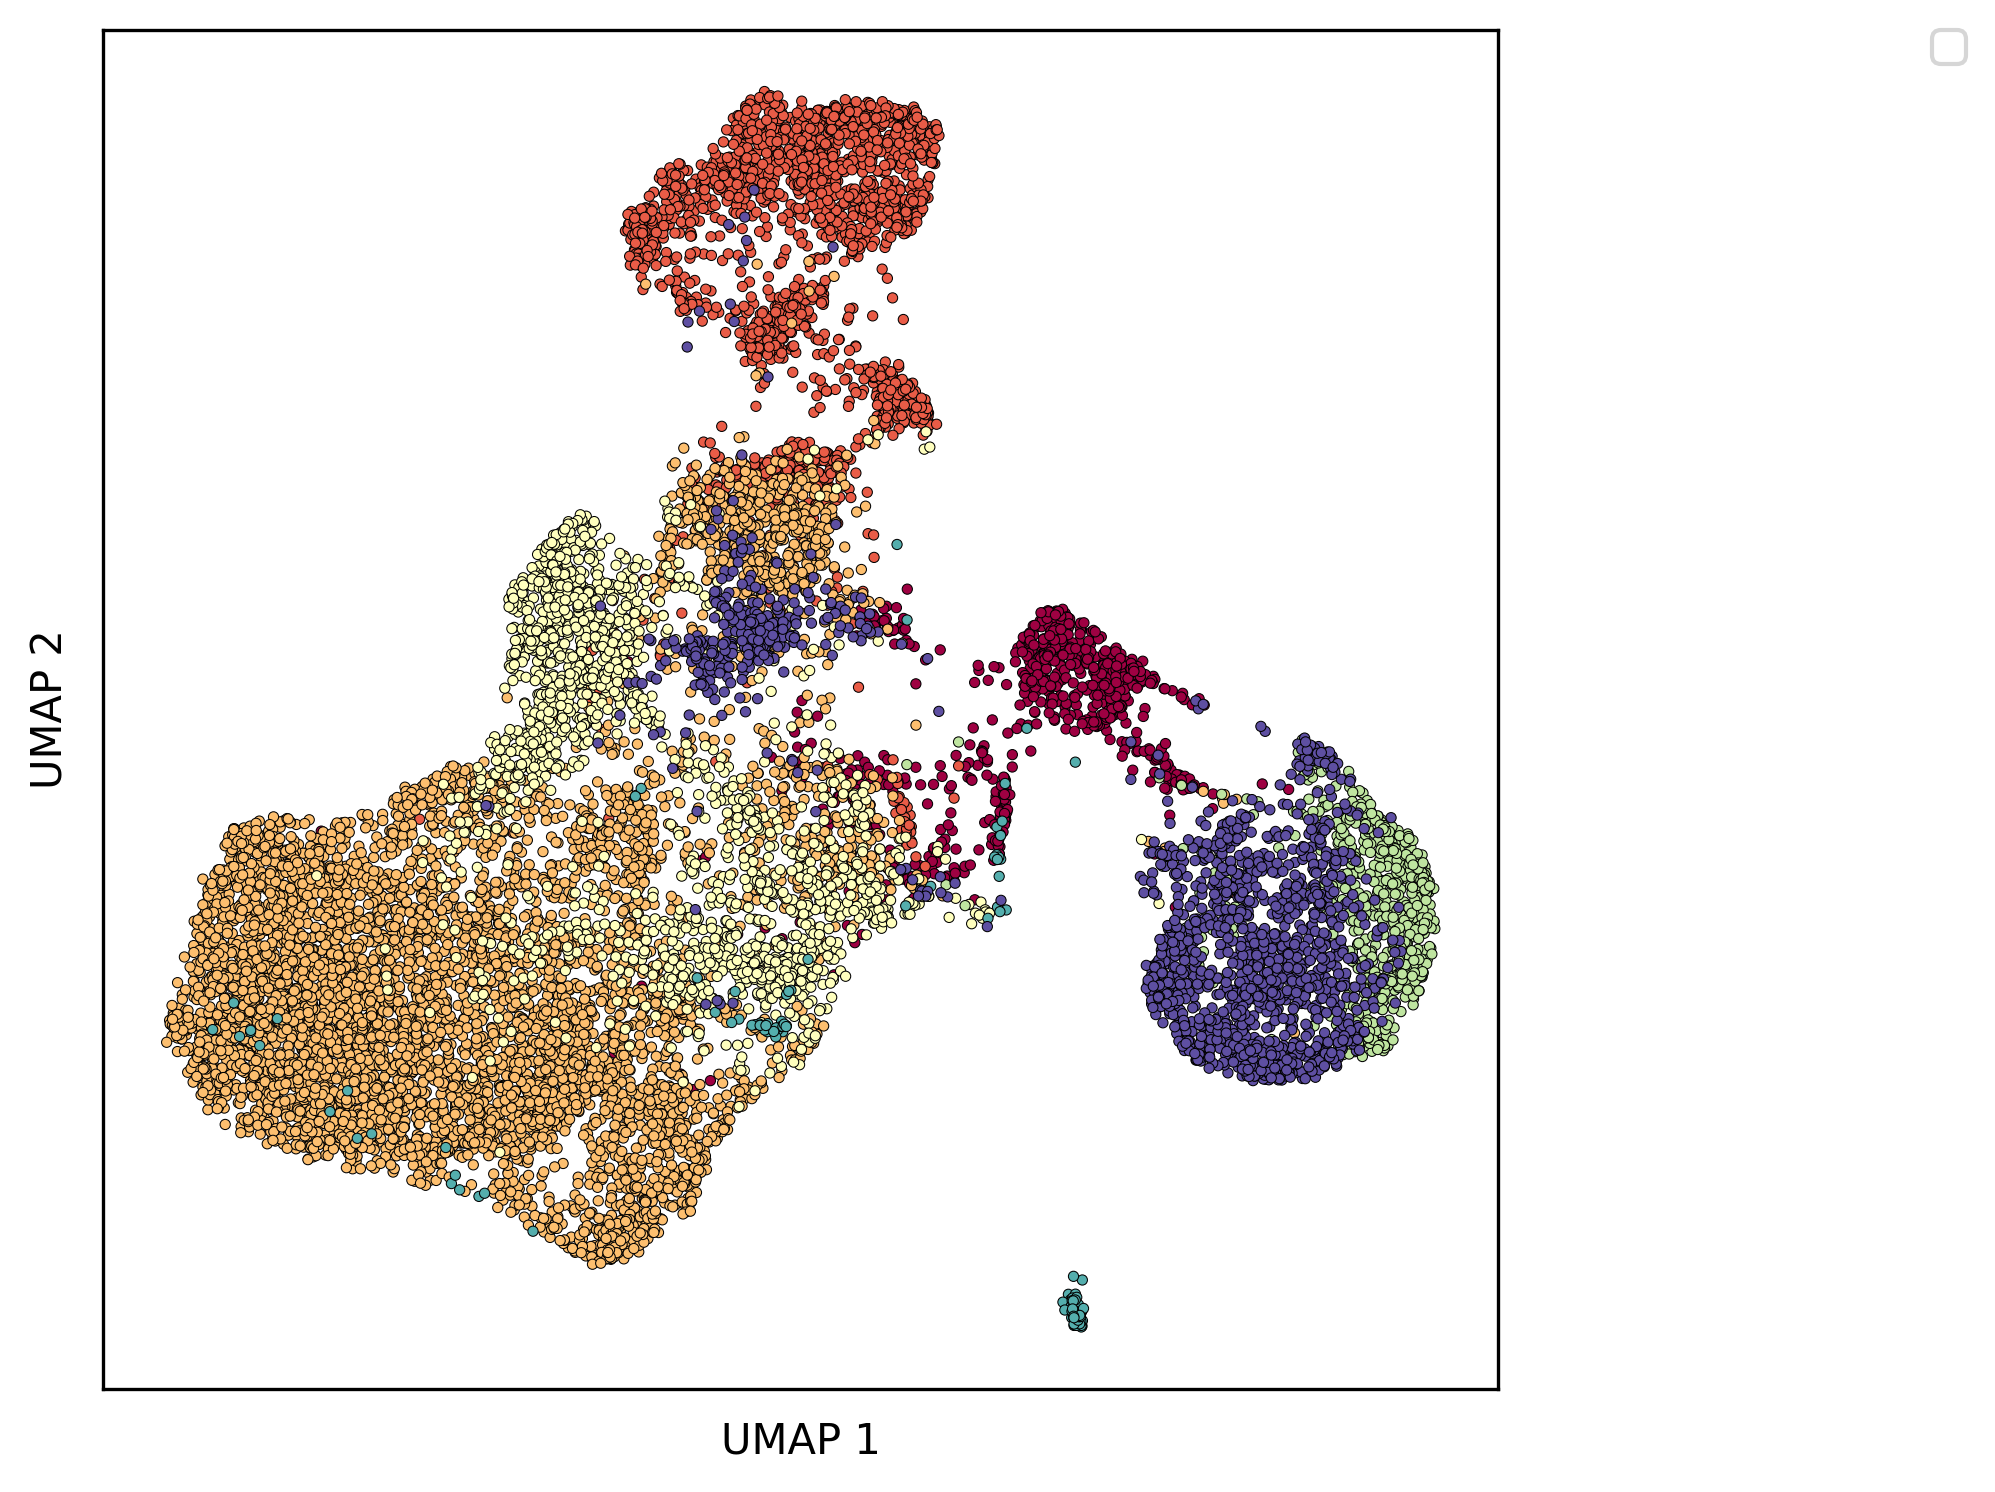

In [14]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6
plt.rcParams['figure.facecolor'] = 'w'

pdf = ef.sort_values(by='cellTypes')

plt.scatter(pdf['x'], 
            pdf['y'], 
            ec='k', 
            lw=0.25,
            c=pdf['colors'],
            s=6)


plt.legend(handles=handles, bbox_to_anchor=(1.35, 1.015))
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

(-5.403929972648621,
 14.539481902122498,
 -4.675648283958435,
 11.807274889945983)

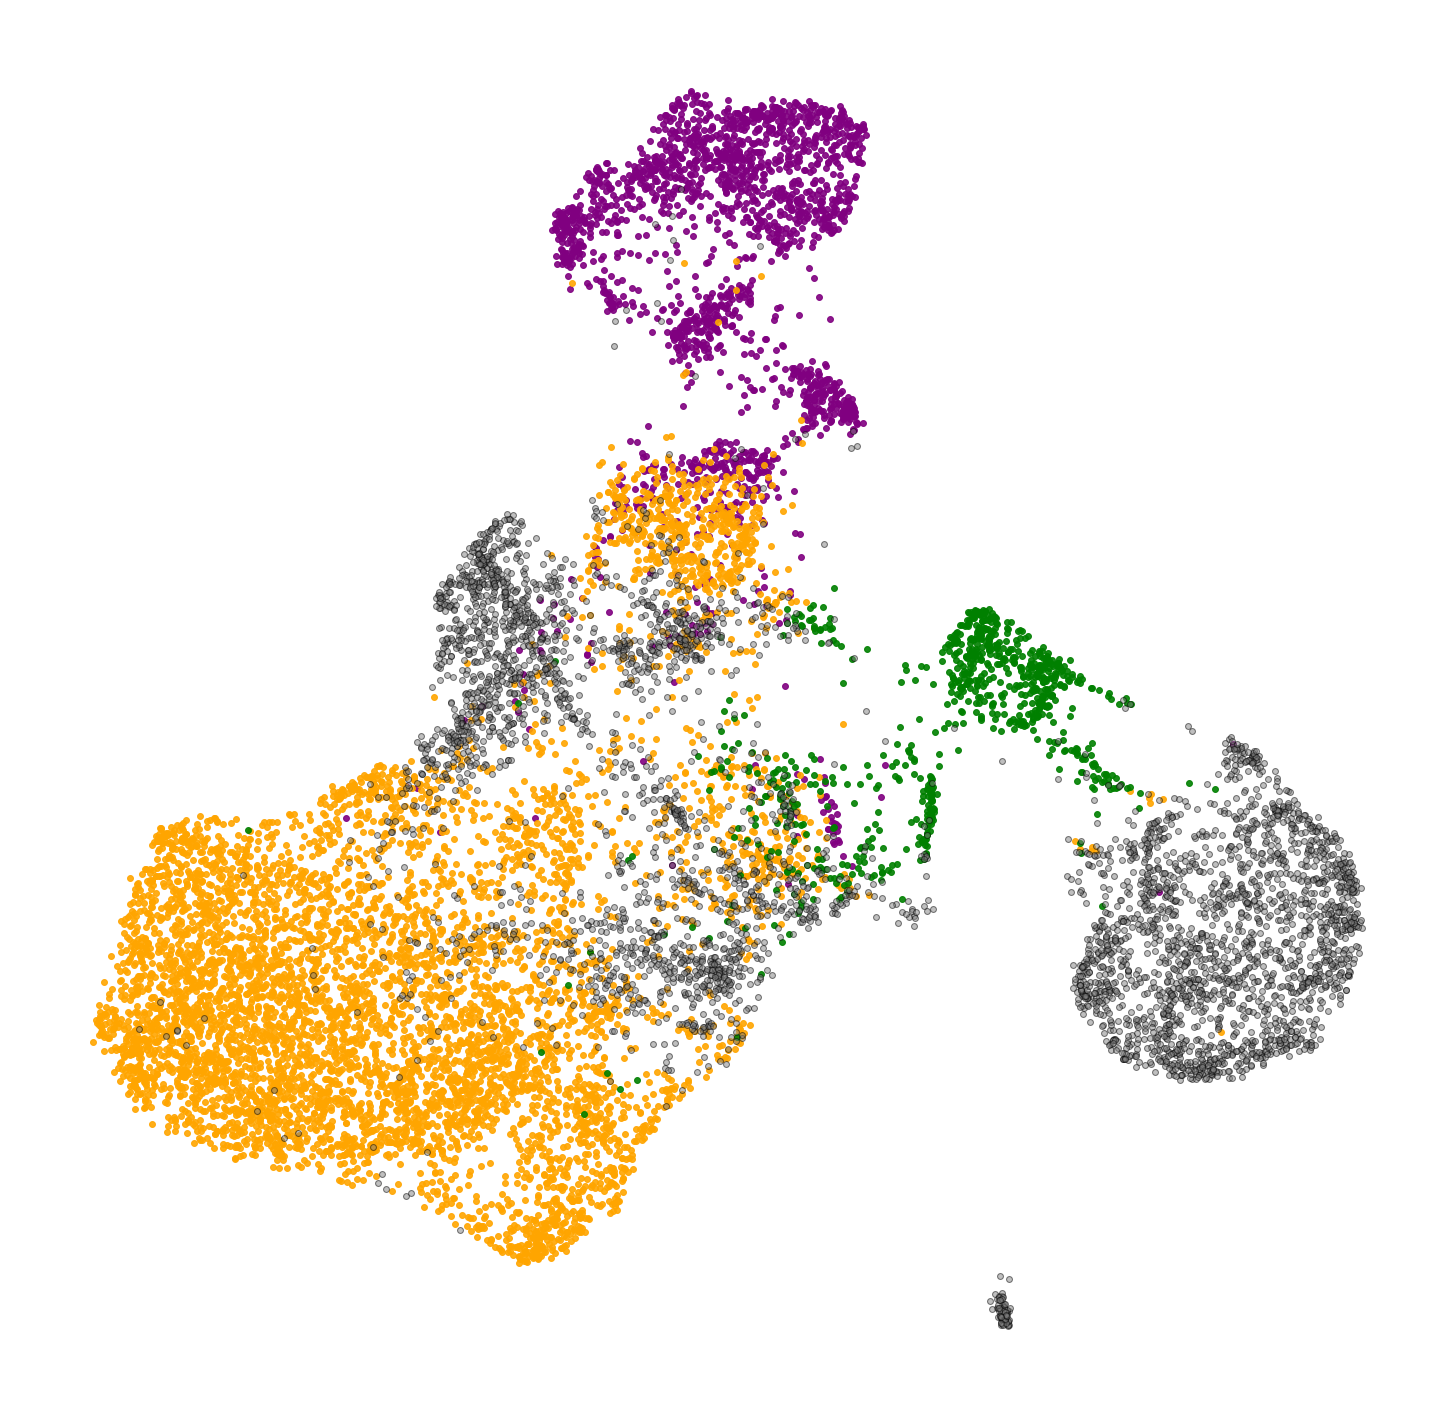

In [15]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6
plt.rcParams['figure.facecolor'] = 'w'

pdf = ef.sort_values(by='cellTypes')

mask1 = (pdf['cellTypes'] == 'Dendritic cells')

plt.scatter(pdf['x'][mask1], 
            pdf['y'][mask1], 
            lw=0.25,
            ec='purple',
            c='purple',
            alpha=0.9,
            s=2)


mask2 = (pdf['cellTypes'] == 'Macrophages')

plt.scatter(pdf['x'][mask2], 
            pdf['y'][mask2], 
            lw=0.25,
            ec='orange',
            c='orange',
            alpha=0.9,
            s=2)


mask3 = (pdf['cellTypes'] == 'B cells')

plt.scatter(pdf['x'][mask3], 
            pdf['y'][mask3], 
            lw=0.25,
            ec='green',
            c='green',
            alpha=0.9,
            s=2)

mask4 = mask1 | mask2 | mask3
plt.scatter(pdf['x'][~mask4], 
            pdf['y'][~mask4], 
            ec='k', 
            lw=0.25,
            c='grey',
            alpha=0.5,
            s=2)

plt.axis(False)

In [16]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 12, 4
plt.rcParams['figure.facecolor'] = 'w'

fig, axs = plt.subplots(1, 3, sharey=True)
axs = axs.ravel()

for i, key in enumerate(keys):

    mask = ef['key'] == key
    pdf = ef.sort_values(by='cellTypes')
    
    axs[i].scatter(pdf['x'][mask], 
                   pdf['y'][mask], 
                   ec='k', 
                   lw=0.25,
                   c=pdf['colors'][mask],
                   zorder=2,
                   s=10)
        
    axs[i].scatter(pdf['x'][~mask], 
                   pdf['y'][~mask], 
                   ec='None', 
                   lw=0.25,
                   c='lightgrey',
                   zorder=1,
                   s=10)

    # axs[i].set_xlabel("UMAP 1")
    # if i == 0:
    #     axs[i].set_ylabel("UMAP 2")
    # else:
    #     axs[i].set_ylabel("")
    # axs[i].set_title(key)
    axs[i].set_xticks([], [])
    axs[i].set_yticks([], [])
    axs[i].axis(False)
    

# plt.legend(handles=handles, bbox_to_anchor=(1.04, 1.02))
plt.tight_layout()

In [ ]:
choose = 50 # number of genes to consider

# load gene lists 
pandPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/panglaodb/pandb.tsv.gz"        
pandf = ut.read_panglaodb(pandPath)

controlList = [
    'Adipocytes',
    'B cells', 
    'Dendritic cells',
    'Macrophages',
    'Monocytes', 
    'NK cells',
    'T cells', 
]

allMarkers = pandf[pandf['cell type'].isin(controlList)]
print(pd.DataFrame(allMarkers['cell type'].value_counts()))
print()
"""
Ubiquitousness Index (0-1). 
0 indicates the gene is not expressed in any cell cluster and 
1 (maximum) indicates that the gene is expressed in all cell clusters. 
"""

mfList = []

for ctype in controlList:
    cf = allMarkers[allMarkers['cell type'] == ctype]
    
    cf = cf.sort_values(by='ubiquitousness index',
                        ascending=True)
    
    mfList.append(cf[['cell type', 'gene']].head(choose))


markerGenes = pd.concat(mfList, ignore_index=True)

"""NOTE: RENAME THE STROMAL CELL POPULATION"""
markerGenes.loc[markerGenes['cell type'] == 'Adipocytes', 'cell type'] = 'Stromal cells'
allMarkers.loc[allMarkers['cell type'] == 'Adipocytes', 'cell type'] = 'Stromal cells'

print()
print(markerGenes.head())


print('done')

In [ ]:
pdf = ef.sort_values(by='cellTypes')
pdf.head()

In [ ]:
res = []

for i, key in enumerate(keys):
    # get RNA Seq data
    rf = rna[key].to_df()
    rf.index = rf.index.str.replace("-", ".")
    
    for c in sorted(ef['cellTypes'].unique()):
        # get the cell type assignments
        mask = (ef['key'] == key) & (ef['cellTypes'] == c)
        pdf = ef[mask].reset_index(drop=True)
        
        # get the marker genes
        mGenes = allMarkers[allMarkers['cell type'] == c]['gene'].to_list()
        mGenes = [x for x in mGenes if x in rf.columns]
        
        # make cell-type specific boolean matrix 
        cf = rf[mGenes].astype(bool).astype(int)
        
        # target matrix for cell type predictions 
        y_true = rf.index.isin(pdf['cellId']).astype(int)
        
        for gene in mGenes:
            y_pred = cf[gene]
            
            tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
            
            row = {
                'key' : key,
                'cellType' : c,
                'color' : colordict[c],
                'gene' : gene,
                'nPred' : np.sum(y_true),
                'true_positive' : tp,
                'true_negative' : tn,
                'false_positive' : fp,
                'false_negative' : fn,
                'sensitivity' : tp / (tp + fn),
                'specificity' : tn / (tn + fp),
                'precision' : tp / (tp + fp),
                'F1' : (2*tp) / ((2*tp) + fp + fn),
            }
            
            res.append(row)
            
            # break
        # break
    # break
    
res = pd.DataFrame(res)
res.head()

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 3.5
plt.rcParams['figure.facecolor'] = 'w'

fig, axs = plt.subplots(1, 3, sharey=True)
axs = axs.ravel()

for i, key in enumerate(keys):
    
    mask = (res['key'] == key)

    sns.boxplot(data=res[mask], 
                    y='cellType',
                    x='precision',
                    showfliers=False, 
                    palette=colordict.values(),
                    # s=5,
                    ax=axs[i])

    axs[i].set_ylabel("")
    axs[i].set_title(key)
    if i == 1:
        axs[i].set_xlabel("Precision")
    else:
        axs[i].set_xlabel("")
    axs[i].legend().remove()
    axs[i].set_xlim([-0.1, 1.1])

In [ ]:
res = []

for i, key in enumerate(keys):
    # get RNA Seq data
    rf = rna[key].to_df()
    rf.index = rf.index.str.replace("-", ".")
    
    for c in sorted(ef['cellTypes'].unique()):
        # get the cell type assignments
        
        kdf = ef[ef['key'] == key]
        cellIds = kdf[(kdf['cellTypes'] == c)]['cellId'].to_list()
        
        # get the marker genes
        mGenes = allMarkers[allMarkers['cell type'] == c]['gene'].to_list()
        mGenes = [x for x in mGenes if x in rf.columns]
        cf = rf[mGenes].mean(axis=1).reset_index(drop=False)
        cf.columns = ['cellId', 'Mean Expression']
        
        mask = cf['cellId'].isin(cellIds)
        
        meanGroup = cf[mask]['Mean Expression']
        meanOther = cf[~mask]['Mean Expression']
        
        lfc = np.log2(meanGroup.mean()) - np.log2(meanOther.mean())
        
        score, pval = scipy.stats.ranksums(meanGroup,
                                           meanOther,
                                           alternative='two-sided')
                
        row = {
            'key' : key,
            'cellType' : c,
            'color' : colordict[c],
            'pval' : pval,
            'score' : score,
            'meanGroup' : meanGroup.mean(),
            'meanOther' : meanOther.mean(),
            'log2foldchange' : lfc
        }
        res.append(row)

    
res = pd.DataFrame(res)
res.head()


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 9, 3
plt.rcParams['figure.facecolor'] = 'w'

sns.barplot(data=res, 
            x='cellType',
            y='log2foldchange',
            hue='key',
            edgecolor='k', 
            palette=['lightgrey','darkgrey',  'grey' ])

plt.xlabel("")
plt.ylabel("Fold Change (log2)")
plt.legend(loc='upper left')


In [ ]:
# cTypes = [
#     'B cells',
#     'Dendritic cells',
#     'Macrophages',
#     'Monocytes',
#     'NK cells',
#     # 'Stromal cells',
#     'T cells',
# ]

# cmap = 'viridis'

# res = []

# for i, key in enumerate(keys):

#     mask = ef['key'] == key
#     pdf = ef.sort_values(by='cellTypes')
    
#     # get RNA Seq data
#     rf = rna[key].to_df()
#     rf.index = rf.index.str.replace("-", ".")
#     res.append(rf)
    
# # build the datadframe
# res = pd.concat(res)
# res = res.fillna(0)


# for c in cTypes:
    
#     plt.rcParams['figure.dpi'] = 300
#     plt.rcParams['figure.figsize'] = 8, 4
#     plt.rcParams['figure.facecolor'] = 'w'
    
#     mGenes = allMarkers[allMarkers['cell type'] == c]['gene'].to_list()
#     mGenes = [x for x in mGenes if x in res.columns]
    
#     trf = pd.DataFrame(res[mGenes].mean(axis=1)).reset_index(drop=False)
#     trf.columns = ['cellId', 'exp']

#     ppdf = pd.merge(pdf, trf, 
#                     left_on='cellId',
#                     right_on='cellId',
#                     how='left')
    
#     fig, axs = plt.subplots(1, 2, sharey=True)
#     axs = axs.ravel()
    
#     mask = (ppdf['cellTypes'] == c)
    
#     axs[0].scatter(ppdf['x'][mask], 
#                    ppdf['y'][mask], 
#                    ec='k', 
#                    lw=0.25,
#                    c=ppdf['colors'][mask],
#                    zorder=2,
#                    s=6)
    
#     axs[0].scatter(ppdf['x'][~mask], 
#                    ppdf['y'][~mask], 
#                    ec='lightgrey', 
#                    lw=0.25,
#                    c='lightgrey',
#                    zorder=1,
#                    s=6)
    
#     axs[0].set_title(f'{c}')
#     axs[0].set_xticks([])
#     axs[0].set_yticks([])
#     axs[0].set_xlabel("UMAP 1")
#     axs[0].set_ylabel("UMAP 2")
    
#     axs[1].scatter(ppdf['x'], 
#                    ppdf['y'], 
#                    ec='k', 
#                    lw=0.25,
#                    c=ppdf['exp'],
#                    cmap=cmap,
#                    zorder=2,
#                    s=6)
    
#     axs[1].set_xticks([])
#     axs[1].set_yticks([])
#     axs[1].set_xlabel("UMAP 1")
#     axs[1].set_title(f'Marker Gene Expression')
    
# #     norm = plt.Normalize(ppdf['exp'].min(),ppdf['exp'].max())
# #     sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# #     sm.set_array([])
# #     cbar = plt.colorbar(sm, 
# #                         ax=axs[1], 
# #                         fraction=0.046, 
# #                         pad=0.04, 
# #                         label=f'Mean Expression')
    
# #     cbar.ax.set_yticklabels([])
# #     cbar.ax.set_title('High', fontsize=10)
# #     cbar.ax.set_xlabel('Low', fontsize=10)
        
    
#     plt.tight_layout()
#     plt.show()
    

In [ ]:
# def makeColorbar(cmap, width, hieght, title, orientation, tickLabels):
#     a = np.array([[0,1]])
#     plt.figure(figsize=(width, hieght))
#     img = plt.imshow(a, cmap=cmap)
#     plt.gca().set_visible(False)
#     cax = plt.axes([0.1, 0.2, 0.8, 0.6])
#     ticks = np.linspace(0,1 , len(tickLabels))
#     cbar = plt.colorbar(orientation=orientation, 
#                         cax=cax, 
#                         label=title,
#                         ticks=ticks)

#     if orientation == 'vertical':
#         cbar.ax.set_yticklabels(tickLabels)
#     else:
#         cbar.ax.set_xticklabels(tickLabels)
    
# makeColorbar("viridis", 0.3, 2, 'Mean Expression', 'vertical', ["Low", "High"])

In [ ]:
break

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['figure.facecolor'] = 'w'

print(ef['cellTypes'].unique())

query = 'Macrophages'
n = 6
cmap = "RdYlBu"
colors = list(reversed(ut.ncolor(n, cmap=cmap)[:3]))
# colors = ['#2329e8', "#f2f252", "#e82323"]
keyMap = dict(zip(ef['key'].unique(), colors))

keyHandles = []

for k, c in keyMap.items():        
    handle = mpatches.Patch(color=c, 
                            ec='k', 
                            label=k)
    keyHandles.append(handle)

pdf = ef.copy()
mask = pdf['cellTypes'] == query

zorder = {
    'ND' : 4,
    'HFD8' : 2,
    'HFD14' : 3
}

for i, key in enumerate(keys):
    
    mask = (pdf['cellTypes'] == query) & (pdf['key'] == key)
    
    kpdf = pdf[mask]
    

    plt.scatter(kpdf['x'], 
                kpdf['y'], 
                ec='k', 
                lw=0.25,
                c=colors[i],
                # alpha=0.7,
                zorder=zorder[key],
                # zorder=2,
                s=10)
    

plt.scatter(pdf['x'][~mask], 
            pdf['y'][~mask], 
            ec='None', 
            lw=0.25,
            c='lightgrey',
            zorder=1,
            s=10)


plt.title(query)
plt.ylim([-3, 7.3])
plt.xlim([-5, 7.5])
plt.legend(handles=keyHandles, bbox_to_anchor=(1.0, 0.81))
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

In [ ]:
ut.ncolor(3, cmap="Spectral_r")

In [ ]:

#     # print(df.head())
    
#     var = df.std(axis=0)
#     mask = var > minStd
#     print(f"{mask.sum()} ({mask.sum() / len(mask):.3f}) genes with std > {minStd}")
    
#     df = df[df.columns[np.where(mask)]]
    
    
#     # df = df[[mask.index.to_lis/t()]]
    
#     # print(df[['MRPL15']].head())
# #     
#     # sc.pp.highly_variable_genes(data, 
#     #                             min_mean=0.0125, 
#     #                             max_mean=3, 
#     #                             min_disp=0.5)
    
#     break
        
#     # get the run key
#     allKeys = list(data.obs.keys())
#     allKeys.remove('n_genes')
#     runKey = allKeys[0]
    
#     clusterIds = data.obs[runKey].astype(int) + 1  # note that these are zero-indexed!
#     embedding = data.obsm['X_umap']

#     # get coloring
#     c = ['k'] * len(embedding)
#     cellType = ['NULL'] * len(embedding)
#     handles = []
    
#     for ctype in ctypes:
#         mask = (cf['cellType'] == ctype) & (cf['key'] == key)
#         cids = cf[mask]['clusterId'].unique()
#         c = np.where(clusterIds.isin(cids), colordict[ctype], c)
#         cellType = np.where(clusterIds.isin(cids), ctype, cellType)
        
#     pdf = pd.DataFrame({'x' : embedding[:, 0], 
#                         'y' : embedding[:, 1]})
    
#     pdf['cellType'] = cellType
#     pdf['Color'] = c
#     pdf['clusterId'] = list(clusterIds)
    
#     pdf['key'] = key
    
#     dfList.append(pdf)
    
    
    
# pdf = pd.concat(dfList, ignore_index=True)


# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 15, 15
# plt.rcParams['figure.facecolor'] = 'w'


# sns.scatterplot(data=pdf, 
#                 x='x', 
#                 y='y', 
#                 ec='k', 
#                 hue='cellType', 
#                 palette='Spectral')